In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
{

Bachelor Degree Mining Optimization Experiment
for B.Sc. Applied Geosciences RWTH Aachen.

Supervised by:  
1. Prof. Dr. Florian Wellmann, CGRE RWTH
2. Dr. Denise Degen, CGRE RWTH

In cooperation with Rheinkalk GmbH (Lhoist Germany):
1. Markus Oehmen, Manager Property,Geology and Mining
2. Raphael Tippelt

}
{

MIT License

Copyright (c) [2022] [Malte Leander Schade]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

}
"""

# python v3.8.12

# built-in modules
import itertools as it

# other modules
import numpy as np  # v1.21.2
import pandas as pd  # v1.3.4
import matplotlib.pyplot as plt  # v3.4.3

import networkx as nx  # v2.5.1

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, providers, IBMQ, Aer, execute  # v0.18.3
from qiskit.circuit.library import PhaseEstimation
from qiskit.visualization import plot_histogram

__author__ = '{Malte_Leander_Schade}'
__copyright__ = 'Copyright {2022}, {quantum_mining_tsp}'
__credits__ = [
    '{https://qiskit.org/textbook/ch-paper-implementations/tsp.html}, {https://arxiv.org/abs/1805.10928}']
__license__ = '{MIT}'
__version__ = '{1}.{0}.{0}'
__maintainer__ = '{Malte_Leander_Schade}'
__status__ = '{Completed}'


In [21]:
n = 3  # Number of blocks/nodes
seed = 102  # RNG cost matrix seed
cost_range = (0, 100)  # RNG cost range
symmetrical = False  # Symmetrical cost matrix

unit_count = 6  # Number of unit registers
shots = 8192  # Shots for each eigenstate

real_qc = False  # Enable real quantum backend
save_csv = False  # Save experimental data


In [22]:
def get_backend(real: bool) -> providers.Backend:
    '''
    Returns a real or simulated quantum computational backend for qiskit.
    Real Quantum Computer: IBMQ Belem 5 Qubit
    Simulated Quantum Computer: Aer Simulator

    ...

    Parameters
    ----------
    real: bool
        Defines if the backend is a real quantum computer.

    Returns
    ----------
    backend: providers.Backend
        A quantum computational backend for qiskit.

    '''
    if real == True:
        # IBMQ.save_account('MY_API_TOKEN')
        IBMQ.load_account()
        provider = IBMQ.get_provider(hub='ibm-q', group='open')
        backend = provider.get_backend('ibmq_belem')
    else:
        backend = Aer.get_backend('aer_simulator')
    return backend


In [23]:
def get_rand_cost(n: int, seed: int, cost_range: tuple, symmetrical: bool) -> np.ndarray:
    '''
    Returns a 2D numpy array of size n*n, filled with seeded random values in
    the provided cost range. The returned array can be symmetrical if specified.
    The diagonal elements of the array are all zero.

    ...

    Parameters
    ----------
    n: int
        The array size.
    seed: int
        An integer seed.
    cost_range: tuple
        A cost range with two values (min/max).
    symmetrical: bool
        If the returned array should be symmetrical. 

    Returns
    ----------
    rand_cost: np.ndarray
        A n*n numpy array filled with random values.

    '''
    rng = np.random.default_rng(seed)
    rand_cost = rng.integers(cost_range[0], cost_range[1], size=(n, n))

    if symmetrical == True:
        rand_cost = np.tril(rand_cost) + np.triu(rand_cost.T)

    np.fill_diagonal(rand_cost, 0)
    return rand_cost


In [24]:
def get_phi_cost(n: int, rand_cost: np.ndarray, cost_range: tuple) -> np.ndarray:
    '''
    Returns a 2D numpy array with same dimension as the input array.
    The array values are min-max normalized to the given cost range. 
    Every value is devided by n to prevent a phase addition to values
    greater than one.

    ...

    Parameters
    ----------
    n: int
        The array size.
    rand_cost: np.ndarray
        An array with dimensions n*n filled with values in the cost range.
    cost_range: tuple
        A cost range with two values (min/max).

    Returns
    ----------
    phi_cost: np.ndarray
        A n*n numpy array filled with values for angle phi.

    '''
    phi_cost = (rand_cost-cost_range[0])/(cost_range[1]-cost_range[0])/n
    return phi_cost


In [25]:
def get_graph(n: int, phi_cost: np.ndarray) -> plt.figure:
    '''
    Draws a directed graph with n nodes. The graphs edges are
    labeled with costs read from the provided 2*2 cost matrix.
    All nodes are connected to all others.

    ...

    Parameters
    ----------
    n: int
        The number of graph nodes.
    phi_cost: np.ndarray
        The edge costs.

    Returns
    ----------
    fig: plt.figure
        A matplotlib figure containing a directed graph with labeled edges.

    '''
    perm_n, comb_n = list(it.permutations(range(n), 2)), list(
        it.combinations(range(n), 2))

    s = ['$\\phi_{', '\\to ', '=', '}$\n $\\phi_{', '\\to ', '=', '}$']
    labels = {p: f'{s[0]}{p[0]}{s[1]}{p[1]}{s[2]}{round(phi_cost[p[0]][p[1]], 3)}'
              f'{s[3]}{p[1]}{s[4]}{p[0]}{s[5]}{round(phi_cost[p[1]][p[0]], 3)}{s[6]}' for p in comb_n}

    Graph = nx.DiGraph(perm_n)
    fig = plt.figure(1, figsize=(10, 10))
    nodePos = nx.circular_layout(Graph)

    nx.draw(Graph, pos=nodePos, with_labels=True, node_color='mediumaquamarine', connectionstyle='arc3, rad = 0.10',
            node_size=3000, arrowsize=14, font_family='serif', font_size=26)

    nx.draw_networkx_edge_labels(
        Graph, edge_labels=labels, pos=nodePos, font_size=16, bbox=dict(alpha=0))
    return fig


In [26]:
def get_bit_size(n: int) -> int:
    '''
    Returns the number of bits needed to represent
    an edge connecting two nodes dependent on the
    node count n.

    ...

    Parameters
    ----------
    n: int
        The node count.

    Returns
    ----------
    bit_size: int
        The number of bits needed to represent an edge.

    '''
    return int(np.ceil(np.log(n)/np.log(2)))


In [27]:
def get_kron(array: np.ndarray, bit_size: int) -> np.ndarray:
    '''
    Constructs diagonal unitary matrices from the columns of the cost matrix
    by calculating e**(phi*i*2*pi) for every phi. The unitary matrices are
    exactly size a*a with a=2**bit_size. Only the n first diagonal elements are
    filled with the phi value. Returns the columnwise kronecker product.

    ...

    Parameters
    ----------
    array: np.ndarray
        A cost matrix filled with phi values.
    bit_size: int
        The number of bits needed to represent an edge.

    Returns
    ----------
    kron: np.ndarray:
        A diagonal unitary matrix filled with n**n non-zero/non-one values. 

    '''
    kron = 1
    for column in np.transpose(array):
        unitary = np.identity(2**bit_size, dtype=complex)
        for i in range(len(column)):
            unitary[i, i] = np.e**(column[i]*1j*2*np.pi)
        kron = np.kron(kron, unitary)
    return kron


In [28]:
def get_eigen_vectors(n: int, eigen_count: int) -> tuple([list, np.ndarray]):
    '''
    Returns all possible hamiltonian circles for a node number n.
    Removes rotated circles but considers flipped ones. Returns
    the binary eigenvector form of all hamiltonian circles scaled up
    to the eigenstate register size.

    ...

    Parameters
    ----------
    n: int
        The node count.
    eigen_count: int
        The bit length of the eigenstate register.

    Returns
    ----------
    eigen_vectors: list
        A list with the eigenvectors as binary strings with length eigen_count.
    hamiltonians: list
        A list with the hamiltonian circles as lists.

    '''
    perm = it.permutations(range(1, n), n-1)
    eigen_vectors, hamiltonians = [], []
    for p in perm:
        p = [0]+list(p)+[0]

        steps = [(b, a) for a, b in zip(p[0:], p[1:])]
        steps.sort(key=lambda x: x[0], reverse=True)
        eigen_int = 0
        for i in range(len(steps)):
            eigen_int += steps[i][1]*4**i

        eigen_vectors.append(np.binary_repr(eigen_int, eigen_count))
        hamiltonians.append(p[:-1])

    return eigen_vectors, hamiltonians


In [29]:
def eigenstates(qc: QuantumCircuit, eigen: QuantumRegister, eigen_value: str) -> QuantumCircuit:
    '''
    Changes the qubits in the eigenstate register to
    a specific eigenvalue by applying X-gates to states
    that need to be in state |1>. 

    ATTENTION: As qiskit interprets the qubits from bottom up
    the eigenstate is set in reverse order.

    ...

    Parameters
    ----------
    qc: QuantumCircuit
        The quantum circuit that the gates are applied to.
    eigen: QuantumRegister
        The quantum register with the eigenstate qubits.
    eigen_value: str
        A string of zeros and ones with the same length as
        the eigenstate register defining the qubit states.

    Returns
    ----------
    qc: QuantumCircuit
        The quantum circuit that the gates were applied to.

    '''
    for i in range(len(eigen)):
        if eigen_value[i] == '1':
            qc.x(eigen[-i-1])
    qc.barrier()
    return qc


In [30]:
def unitary(qubit_count: int, u: np.ndarray) -> QuantumCircuit.to_gate:
    '''
    Returns a unitary qiskit gate acting on a defined
    number of qubits and constructed from a unitary u. 

    ...

    Parameters
    ----------
    qubit_count: int
        The number of qubits the gate will act on.
    u: np.ndarray
        A unitary diagonal matrix with a size fitted
        to act on qubit_count qubits.

    Returns
    ----------
    qc: QuantumCircuit.to_gate
        The quantum circuit as a gate usable in
        other quantum circuits.

    '''
    eigen = QuantumRegister(qubit_count)
    qc = QuantumCircuit(eigen)
    qc.diagonal(list(np.diag(u)), eigen)
    return qc.to_gate(label='U')


In [31]:
def execute_qc(kron: np.ndarray, unit_count: int, eigen_count: int, eigen_vectors: list, hamiltonians: list, symmetrical: bool, backend: providers.Backend, shots: int) -> tuple([pd.DataFrame, int]):
    '''
    Builds and executes a circuit for quantum phase estimation on a provided backend.
    An eigenvector is encoded in an eigenstate register and determines which phase
    of a controlled unitary is kicked back to a definable number of qubits
    in superposition in a phase estimation register. The phase is transformed from the
    Fourier basis to the Z-basis with inverse quantum Fourier transformation and is
    measured to a classical register. The combined angle phi of the hamiltonian circle
    is calculated from the measurement. An array containing experimental results and 
    the index of the eigenstate with smallest phi is returned. 

    ATTENTION:
    Does not scale on classical computers!

    ...

    Parameters
    ----------
    kron: np.ndarray:
        A diagonal unitary matrix filled with n**n non-zero/non-one values. 
    unit_count: int
        The number of qubits in the phase estimation register. Higher numbers
        result in more distinguishable states and higher accuracy.
    eigen_count: int
        The bit length of the eigenstate register.
    eigen_vectors: list
        A list with the eigenvectors as binary strings with length eigen_count.
    hamiltonians: list
        A list with the hamiltonian circles as lists.
    symmetrical: bool
        If the cost matrix is symmetrical. 
    backend: providers.Backend
        A quantum computational backend for qiskit.
    shots: int
        The number of executions for each eigenstate.

    Returns
    ----------
    results_df: pd.DataFrame
        The experimental results for each eigenstate with:
            Column[0] = The hamiltonian circle
            Column[1] = The most often measured state in the phase estimation register
            Column[2] = The corresponding angle phi
            Column[3] = All measurement counts as a list
    min_index: int
        The index of the eigenstate with smallest angle phi. 

    '''
    print(f'Execution started with backend: {backend}')
    print(
        f'Constructing phase estimation circuit with {unit_count} evaluation qubits and {eigen_count} eigenstate qubits')

    qpe = PhaseEstimation(unit_count, unitary(eigen_count, kron))

    print('Construction completed')
    print(
        f'---- Starting distance calculation with {len(hamiltonians)} hamiltonian circles ----')
    results = []
    for i in range(len(eigen_vectors)):
        unit = QuantumRegister(unit_count, 'unit')
        eigen = QuantumRegister(eigen_count, 'eigen')
        unit_classical = ClassicalRegister(unit_count, 'unit_classical')
        qc = QuantumCircuit(unit, eigen, unit_classical)

        eigenstates(qc, eigen, eigen_vectors[i])

        qc.append(qpe, range(unit_count+eigen_count))

        qc.barrier()

        qc.measure(unit, unit_classical[::-1])

        job = execute(qc, backend, shots=shots)
        count = job.result().get_counts()
        max_bin = max(count, key=count.get)
        result = int(max_bin, 2)/2**(unit_count)
        results.append([hamiltonians[i], max_bin, result, count])
        print(
            f'Hamiltonian Path: {results[-1][0]}, Eigenstate: {eigen_vectors[i]}, Measured State: {results[-1][1]}, Total Angle: {results[-1][2]} phi')

    min_index = np.argmin(np.array(results, dtype=object)[:, 2])

    if symmetrical == True:
        print(
            f'---- The shortest path is {results[min_index][0]} in both directions with phi = {results[min_index][2]} ----')
    elif symmetrical == False:
        print(
            f'---- The shortest path is {results[min_index][0]} in one direction with phi = {results[min_index][2]} ----')

    results_df = pd.DataFrame(
        results, columns=['hamiltonian', 'max_measure', 'phi', 'all_measure'])
    print('Execution finished')

    # qc.draw('mpl', filename='circuit.png')

    return results_df, min_index


In [32]:
# Calculation of the random cost matrix
rand_cost = get_rand_cost(n, seed, cost_range, symmetrical)

# Normalisation of the matrix to fitting values for phi
phi_cost = get_phi_cost(n, rand_cost, cost_range)

# Calculation of the number of bits needed to label a path
bit_size = get_bit_size(n)

# Calculation of the bit length of the hamiltonian eigenvalues
eigen_count = bit_size*n

# Calculation of the kronecker product diagonal unitary
kron = get_kron(phi_cost, bit_size)

# Calculation of all the eigenvalues as bitstrings and the connected hamiltonian circles
eigen_vectors, hamiltonians = get_eigen_vectors(n, eigen_count)

print(f'bit_size: {bit_size}, eigen_count: {eigen_count}, kron_size: {len(kron)}^2, hamiltonian_circles: {len(hamiltonians)}')


bit_size: 2, eigen_count: 6, kron_size: 64^2, hamiltonian_circles: 2


In [33]:
# Randomized cost matrix
pd.DataFrame(rand_cost)  # .to_csv('rand_cost.csv')


,0,1,2
0,0,15,54
1,58,0,82
2,28,29,0


In [34]:
# Randomized cost matrix converted to phi values
pd.DataFrame(phi_cost)  # .to_csv('phi_cost.csv')


,0,1,2
0,0.000000,0.050000,0.180000
1,0.193333,0.000000,0.273333
2,0.093333,0.096667,0.000000


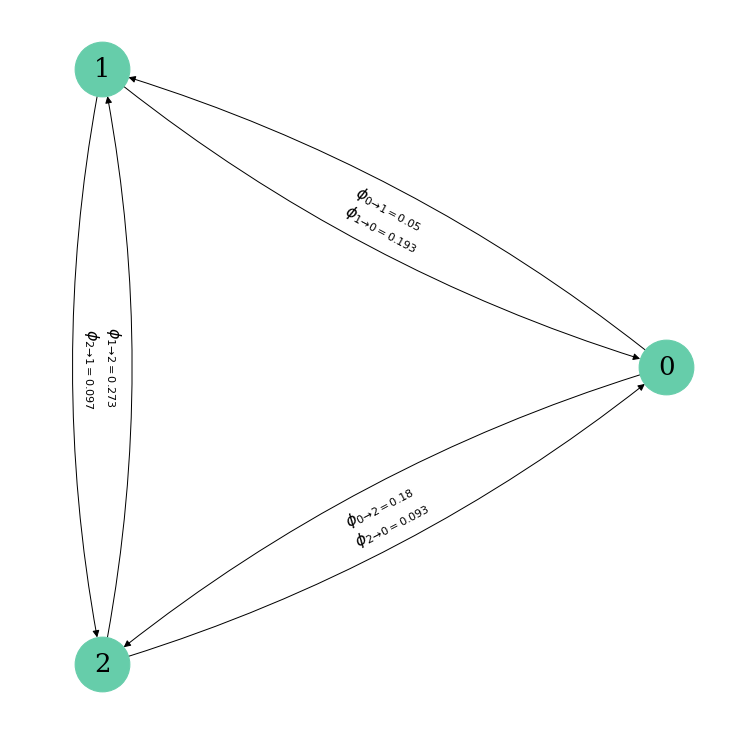

In [35]:
# Directed graph generation
_ = get_graph(n, phi_cost)  # .savefig('graph.png')


In [36]:
# Backend for quantum code execution is defined
backend = get_backend(real_qc)

# Execution of the quantum experiment
results, min_index = execute_qc(kron, unit_count, eigen_count,
                                eigen_vectors, hamiltonians, symmetrical, backend, shots)


Execution started with backend: aer_simulator
Constructing phase estimation circuit with 6 evaluation qubits and 6 eigenstate qubits
Construction completed
---- Starting distance calculation with 2 hamiltonian circles ----
Hamiltonian Path: [0, 1, 2], Eigenstate: 100001, Measured State: 011011, Total Angle: 0.421875 phi
Hamiltonian Path: [0, 2, 1], Eigenstate: 011000, Measured State: 011110, Total Angle: 0.46875 phi
---- The shortest path is [0, 1, 2] in one direction with phi = 0.421875 ----
Execution finished


In [37]:
# Experimental results are saved as csv and named with parameters and timestamp
if real_qc == True or save_csv == True:
    stamp = str(pd.Timestamp.now())[:19].replace(' ', '_')
    filename = f'{n}_{seed}_{cost_range[0]}_{cost_range[1]}_{str(int(symmetrical))}_{unit_count}_{shots}_{stamp}.csv'
    results.to_csv(filename)


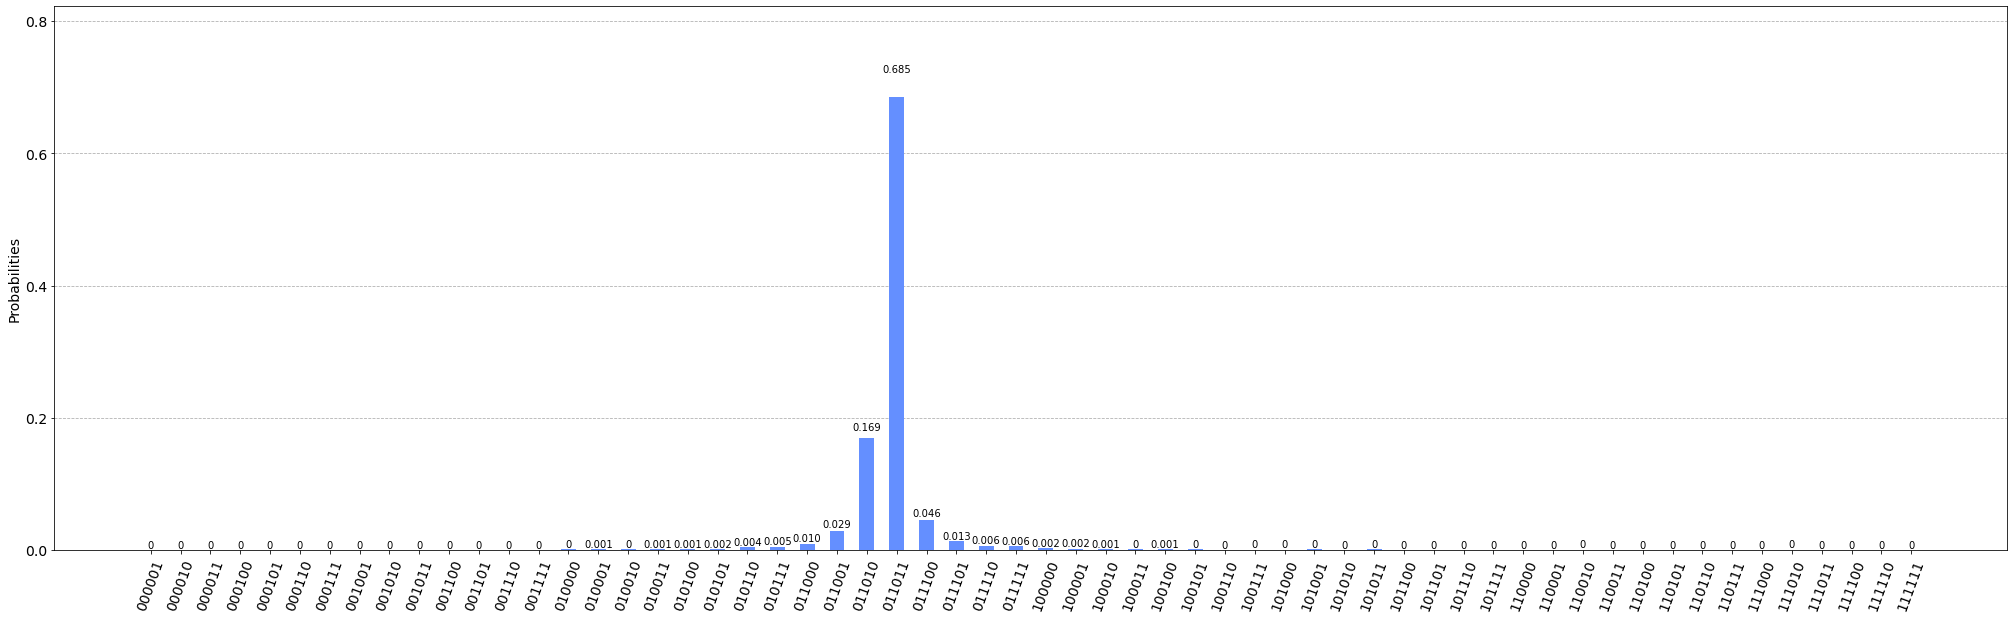

In [38]:
# A histogram displaying all measurements for the shortest hamiltonian circle is drawn
plot_histogram(results['all_measure'][min_index],
               figsize=(35, 10))  # .savefig('hist.png')
